In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


## Read in the family information and sample submission

In [3]:
fpath = 'family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = 'sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

In [4]:
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [5]:
submission.head()

,assigned_day
family_id,
0,100
1,99
2,98
3,97
4,96


In [6]:
data.groupby('choice_0')['choice_0'].count().index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
             14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
             27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
             40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
             53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
             66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
             79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
             92,  93,  94,  95,  96,  97,  98,  99, 100],
           dtype='int64', name='choice_0')

## Exploring the Family Data

In [7]:
# Setting base date as Christmas Eve
import datetime
base = datetime.datetime(2019,12,24,00)
base

datetime.datetime(2019, 12, 24, 0, 0)

In [8]:
# Creating datelist for all 100 days before christmas
date_list = [base - datetime.timedelta(days=x) for x in range(100)]
date_list[:4]

[datetime.datetime(2019, 12, 24, 0, 0),
 datetime.datetime(2019, 12, 23, 0, 0),
 datetime.datetime(2019, 12, 22, 0, 0),
 datetime.datetime(2019, 12, 21, 0, 0)]

In [9]:
# Creating date datafrae with day of week number (0 = Monday)
date_index = pd.DataFrame(date_list,columns=['date'])
date_index['day'] = date_index['date'].apply(lambda x: x.dayofweek)
date_index.index += 1 
date_index

,date,day
1,2019-12-24,1
2,2019-12-23,0
3,2019-12-22,6
4,2019-12-21,5
5,2019-12-20,4
...,...,...
96,2019-09-20,4
97,2019-09-19,3
98,2019-09-18,2
99,2019-09-17,1


In [10]:
# Creating column with day of week for choice_0
date_dict = date_index.day.to_dict()
data['choice_0_day']= data['choice_0'].map(date_dict)

In [11]:
data

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people,choice_0_day
family_id,,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4,6
1,26,4,82,5,11,47,38,6,66,61,4,4
2,100,54,25,12,27,82,10,89,80,33,3,0
3,2,95,1,96,32,6,40,31,9,59,2,0
4,53,1,47,93,26,3,46,16,42,39,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,16,1,66,33,18,70,56,46,86,60,4,0
4996,88,66,20,17,26,54,81,91,59,48,2,5
4997,32,66,54,17,27,21,74,81,3,7,6,5


## Exploring the distribution of choice_0 requests below, Christmas Eve is the overwhelming choice and weekends (Fri-Sun) are popular as well

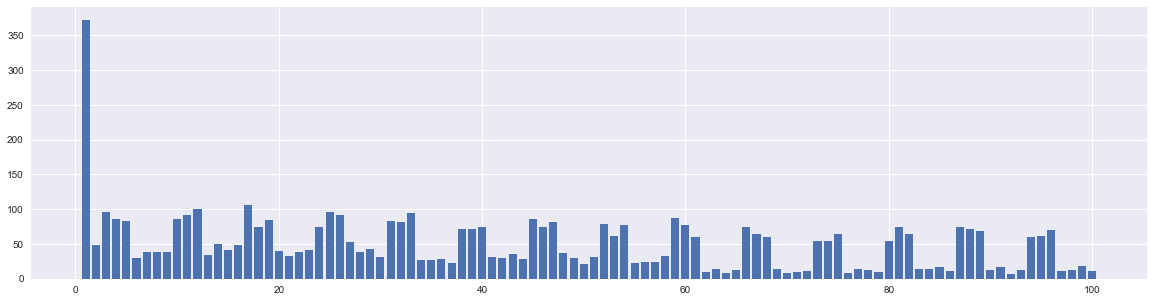

In [12]:
plt.close('all')
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,5))

bar = ax.bar(data.groupby('choice_0')['choice_0'].count().index,data.groupby('choice_0')['choice_0'].count().values)

## The majority of choice_1 are for dates before the choice_0, due to the majority of choice_0 being the last day, Christmas Eve

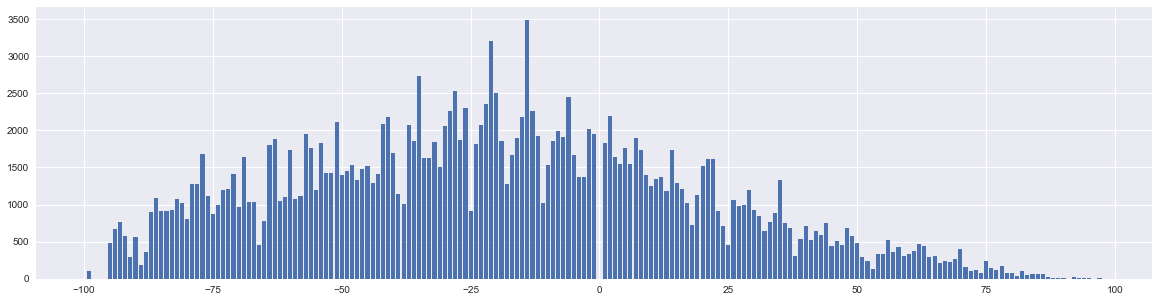

In [13]:
plt.close('all')
plt.style.use('seaborn')


fig, ax = plt.subplots(figsize=(20,5))

bar = ax.bar(data.groupby((data['choice_1'] - data['choice_0'])).agg('sum',axis="columns")['choice_0'].index,\
       data.groupby((data['choice_1'] - data['choice_0'])).agg('sum',axis="columns")['choice_0'])

In [14]:
data.groupby('choice_0_day').count()['choice_0']

choice_0_day
0     391
1     714
2     349
3     344
4    1073
5    1041
6    1088
Name: choice_0, dtype: int64

## Most preferences are for Friday, Saturday, Sunday. Tuesday is Christmas Eve

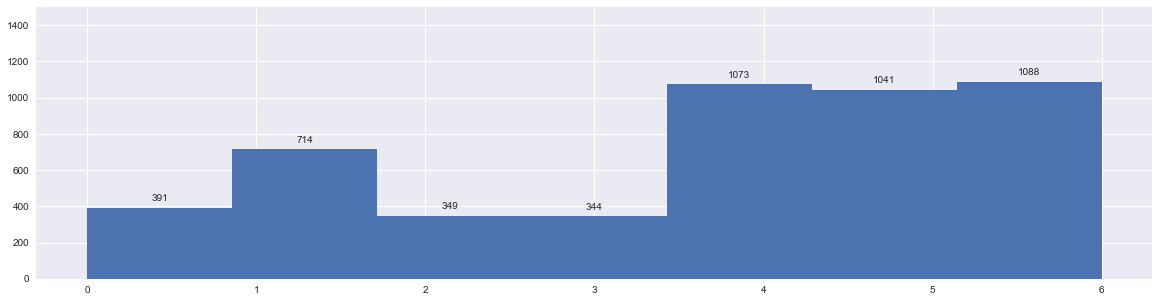

In [15]:
plt.close('all')
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,5))

hist = ax.hist(data['choice_0_day'].astype('int'),bins=7)
ax.set(ylim=(0,1500))

add_value_labels(ax)

In [16]:
# Reset occupancy
columns = ['pref_0', 'pref_1', 'pref_2', 'pref_3', 'pref_4', 'pref_5',
       'pref_6', 'pref_7', 'pref_8', 'pref_9','pref_10','total']
occupancy = pd.DataFrame(0,index=date_index.index,columns=columns)

occupancy.head()

,pref_0,pref_1,pref_2,pref_3,pref_4,pref_5,pref_6,pref_7,pref_8,pref_9,pref_10,total
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0


## Creating Daily Limits Function

In [18]:
# loops = 100
# for i in range(100):
#     data['picked_choice_{}'.format(i)] = 10
#     data['picked_day_{}'.format(i)] = -2
    

In [223]:
def daily_limit(choice,n_people,pref,remaining):

    min_choice = occupancy['total'].idxmin() #for any unassigned families, put them in smallest bucket
    
    # Looping through all family choices until finding match and ensuring buckets get filled to 150 at least
    if occupancy.loc[choice]['total'] + n_people <= 300 and pref < 9:
        if remaining > occupancy[occupancy['total'] < 150]['total'].sum() + n_people:
            if occupancy.loc[choice]['total'] < 150: # Can add people to bucket with less than the min
                occupancy.loc[choice]['pref_{}'.format(pref)] += n_people
                occupancy.loc[choice]['total'] += n_people
                return 1 #Should stop iterating when adding to occupancy df
            else:
                return 0
        else:
            return 0 #Should continue iterating through choices when buckets need to be filled
        
    if occupancy.loc[choice]['total'] + n_people <= 300 and pref == 9:
        occupancy.loc[min_choice]['pref_10'] += n_people # this needs to be updated to account for actual preference when its the same (or maybe top 10 buckets?)
        occupancy.loc[min_choice]['total'] += n_people
        return 2
    
    else:
        return 0 #Should continue iterating through choices
    
    

## New loop with additional daily limit function added

In [224]:
# Testing logic for dynamically looking at choices
j = 0

# Reset occupancy dataframe
columns = ['pref_0', 'pref_1', 'pref_2', 'pref_3', 'pref_4', 'pref_5',
       'pref_6', 'pref_7', 'pref_8', 'pref_9','pref_10','total']
occupancy = pd.DataFrame(0,index=date_index.index,columns=columns)

# Create submission dataframe
submission = pd.DataFrame(data,columns=['assigned_day'])

remaining = 20968 # total number of people

for index,row in data.iterrows():
    for i in range(10):
        choice = row['choice_{}'.format(i)]
        n_people = row['n_people']
        family_id = index
        
        # Runs occupancy filling function from highlest to lowest preference
        add_check = daily_limit(choice,n_people,i,remaining)
        
        if add_check == 1:
            remaining -= n_people # Removing added people
            submission.iloc[family_id] = choice.astype('int')
            break
        if add_check == 2:
            min_choice = occupancy['total'].idxmin() # for any unassigned families, put them in smallest bucket
            submission.iloc[family_id] = min_choice
            break
        if add_check == 0:
            pass
        else:
            assert False, 'Error with add_check'

In [225]:
occupancy.head()

,pref_0,pref_1,pref_2,pref_3,pref_4,pref_5,pref_6,pref_7,pref_8,pref_9,pref_10,total
1,155,0,0,0,0,0,0,0,0,0,55,210
2,124,3,11,8,0,0,0,4,0,0,58,208
3,145,6,0,0,0,0,0,0,0,0,61,212
4,139,10,4,0,0,0,0,0,0,0,59,212
5,129,18,3,0,0,0,0,0,0,0,59,209


In [226]:
submission.head()

,assigned_day
family_id,
0,52.0
1,26.0
2,100.0
3,2.0
4,53.0


In [227]:
submission.groupby('assigned_day')['assigned_day'].transform('count')

family_id
0       49
1       54
2       49
3       47
4       49
        ..
4995    50
4996    48
4997    48
4998    51
4999    44
Name: assigned_day, Length: 5000, dtype: int64

In [234]:
submission.to_csv('submission.csv',sep=',')

In [264]:
labels

['pref_0',
 'pref_1',
 'pref_2',
 'pref_3',
 'pref_4',
 'pref_5',
 'pref_6',
 'pref_7',
 'pref_8',
 'pref_9',
 'pref_10']

In [265]:
pref_10

[55,
 58,
 61,
 59,
 59,
 57,
 56,
 61,
 57,
 57,
 53,
 58,
 59,
 52,
 57,
 60,
 65,
 58,
 60,
 59,
 59,
 62,
 56,
 58,
 56,
 56,
 57,
 57,
 63,
 62,
 61,
 55,
 61,
 57,
 58,
 63,
 57,
 62,
 59,
 55,
 55,
 60,
 61,
 59,
 56,
 57,
 59,
 60,
 61,
 60,
 60,
 58,
 56,
 61,
 60,
 61,
 60,
 60,
 59,
 57,
 64,
 110,
 122,
 118,
 122,
 58,
 57,
 57,
 117,
 139,
 135,
 110,
 59,
 60,
 59,
 110,
 93,
 96,
 117,
 53,
 57,
 58,
 115,
 127,
 78,
 103,
 62,
 60,
 58,
 111,
 118,
 101,
 127,
 54,
 56,
 55,
 95,
 118,
 131,
 76]

In [251]:
labels = list(occupancy.columns)[:11]

pref_0 = list(occupancy['pref_0'].values)
pref_1 = list(occupancy['pref_1'].values)
pref_2 = list(occupancy['pref_2'].values)
pref_3 = list(occupancy['pref_3'].values)
pref_4 = list(occupancy['pref_4'].values)
pref_5 = list(occupancy['pref_5'].values)
pref_6 = list(occupancy['pref_6'].values)
pref_7 = list(occupancy['pref_7'].values)
pref_8 = list(occupancy['pref_8'].values)
pref_9 = list(occupancy['pref_9'].values)
pref_10 = list(occupancy['pref_10'].values)

x = list(occupancy.index.values)


## The chart below shows that way too many people are getting either their first or last choice

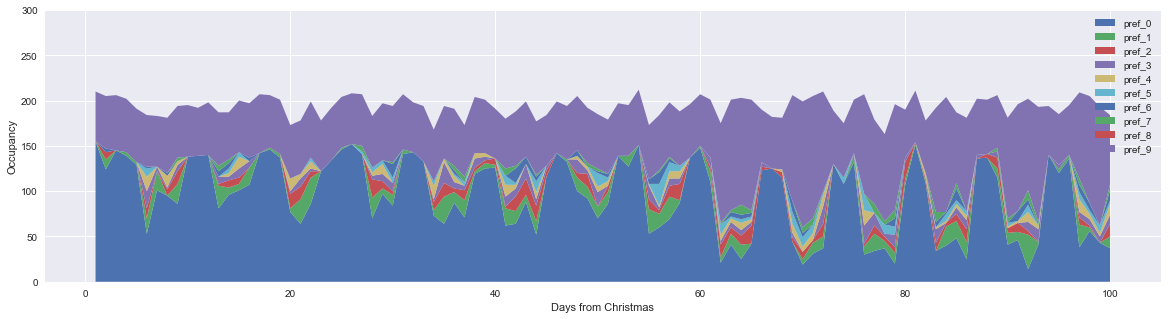

In [269]:
plt.close('all')
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,5))

ax.set_xlabel('Days from Christmas')
ax.set_ylabel('Occupancy')
ax.set_ylim(0,300)

ax.stackplot(x,pref_0,pref_2,pref_3,pref_4,pref_5,pref_6,pref_7,pref_8,pref_9,pref_10,labels=labels)
ax.legend(loc=1)

plt.show()

In [235]:
def top_pref_penalty(pref,d):
    
    penalty = 0
    n = pref
    
    d = d
    if pref > 0:
        if d == 0:
            penalty += 0
        elif d == 1:
            penalty += 50
        elif d == 2:
            penalty += 50 + 9 * n
        elif d == 3:
            penalty += 100 + 9 * n
        elif d == 4:
            penalty += 200 + 9 * n
        elif d == 5:
            penalty += 200 + 18 * n
        elif d == 6:
            penalty += 300 + 18 * n
        elif d == 7:
            penalty += 300 + 36 * n
        elif d == 8:
            penalty += 400 + 36 * n
        elif d == 9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n
    else:
        pass
        
    return penalty

In [236]:
occupancy['pref_pen'] = 0

# Applies preference penalty across all preference columns (pref_#) and sums to one column
for i in range(10):
    occupancy['pref_pen'] += occupancy.apply(lambda x: top_pref_penalty(x['pref_{}'.format(i)],i),axis=1)

In [237]:
occupancy

,pref_0,pref_1,pref_2,pref_3,pref_4,pref_5,pref_6,pref_7,pref_8,pref_9,pref_10,total,pref_pen,acct_cost,total_cost
1,155,0,0,0,0,0,0,0,0,0,55,210,0,3,3
2,124,3,11,8,0,0,0,4,0,0,58,208,815,4,819
3,145,6,0,0,0,0,0,0,0,0,61,212,50,3,53
4,139,10,4,0,0,0,0,0,0,0,59,212,136,4,140
5,129,18,3,0,0,0,0,0,0,0,59,209,127,3,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,136,13,4,0,0,0,0,0,0,0,55,208,136,4,140
97,38,2,25,8,6,14,8,8,7,0,95,211,2887,3,2890
98,56,5,4,2,7,6,4,8,0,0,118,210,1785,3,1788
99,43,15,0,0,7,4,8,0,0,0,131,208,1029,2,1031


## Accounting cost for all days
#### Accounting costs grow exponentially when the gap between daily volumes is large

In [238]:
occupancy['acct_cost'] = 0
days = list(range(100,0,-1))

# First day is special
occupancy.loc[100]['acct_cost'] = (occupancy.loc[days[0]]['total']-125.0) / 400.0 * occupancy.loc[days[0]]['total']**(0.5)

# Loop over the rest of the days, keeping track of previous count
yesterday_count = occupancy.loc[days[0]]['total']
for day in days[1:]:
    today_count = occupancy.loc[day]['total']
    diff = abs(today_count - yesterday_count)
    occupancy.loc[day]['acct_cost'] = max(0, (occupancy.loc[day]['total']-125.0) / 400.0 *\
                           occupancy.loc[day]['total']**(0.5 + diff / 50.0))
    yesterday_count = today_count

occupancy.head(20)

,pref_0,pref_1,pref_2,pref_3,pref_4,pref_5,pref_6,pref_7,pref_8,pref_9,pref_10,total,pref_pen,acct_cost,total_cost
1,155,0,0,0,0,0,0,0,0,0,55,210,0,3,3
2,124,3,11,8,0,0,0,4,0,0,58,208,815,4,819
3,145,6,0,0,0,0,0,0,0,0,61,212,50,3,53
4,139,10,4,0,0,0,0,0,0,0,59,212,136,4,140
5,129,18,3,0,0,0,0,0,0,0,59,209,127,3,130
6,53,27,17,11,19,16,9,2,0,0,57,211,2145,4,2149
7,101,25,21,0,5,0,0,0,0,0,56,208,534,4,538
8,95,31,0,7,2,13,0,3,0,0,61,212,1273,3,1276
9,86,18,22,14,7,4,0,0,4,0,57,212,1603,4,1607
10,138,13,0,0,0,0,0,0,0,0,57,208,50,3,53


In [239]:
occupancy['total_cost'] = occupancy['pref_pen'] + occupancy['acct_cost']
'{0:,}'.format(occupancy['total_cost'].sum())

'112,020'

## Create some lookup dictionaries and define constants

You don't need to do it this way. :-)

In [28]:
family_size_dict = data[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

## Cost Function
Very un-optimized  ;-)

In [204]:
def cost_function(prediction):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}

    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n

    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count

    penalty += accounting_cost

    return penalty

## Simple Opimization Approach

For each family, loop over their choices, and if keep it if the score improves. There's a lot of easy improvement that can be made to this code.

In [207]:
# Start with the sample submission values
best = submission['assigned_day'].tolist()
start_score = cost_function(best)

new = best.copy()
# loop over each family
for fam_id, _ in enumerate(best):
    # loop over each family choice
    for pick in range(10):
        day = choice_dict[f'choice_{pick}'][fam_id]
        temp = new.copy()
        temp[fam_id] = day # add in the new pick
        if cost_function(temp) < start_score:
            new = temp.copy()
            start_score = cost_function(new)

submission['assigned_day'] = new
score = cost_function(new)
submission.to_csv(f'submission_{score}.csv')
print(f'Score: {score}')

Score: 672254.0276683343


## scrap

In [39]:
# Creating my empty occupancy dataframe for controlling limits
occupancy = pd.DataFrame(0,index=date_index.index,columns=['occ_count'])
occupancy

,occ_count
1,0
2,0
3,0
4,0
5,0
...,...
96,0
97,0
98,0
99,0


In [40]:
# Creating trimmed dataframe of non-peak requests (Mon-Thur) and non-Xmas Eve
non_weekend_or_xmas = data.where(~data.choice_0_day.isin([4,5,6])&data.choice_0_day != 1).dropna()
non_weekend_or_xmas.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people,choice_0_day
family_id,,,,,,,,,,,,
0,52.0,38.0,12.0,82.0,33.0,75.0,64.0,76.0,10.0,28.0,4.0,6.0
1,26.0,4.0,82.0,5.0,11.0,47.0,38.0,6.0,66.0,61.0,4.0,4.0
2,100.0,54.0,25.0,12.0,27.0,82.0,10.0,89.0,80.0,33.0,3.0,0.0
3,2.0,95.0,1.0,96.0,32.0,6.0,40.0,31.0,9.0,59.0,2.0,0.0
4,53.0,1.0,47.0,93.0,26.0,3.0,46.0,16.0,42.0,39.0,4.0,5.0


In [41]:
# Adding non-peak requests to occupancy dataframe
for index,row in non_weekend_or_xmas.iterrows():
    occupancy['occ_count'][row['choice_0']] += row['n_people']
#     print(index,row['n_people'])

## Giving every non-weekend and Xmas Eve their first choice, creates conflicts

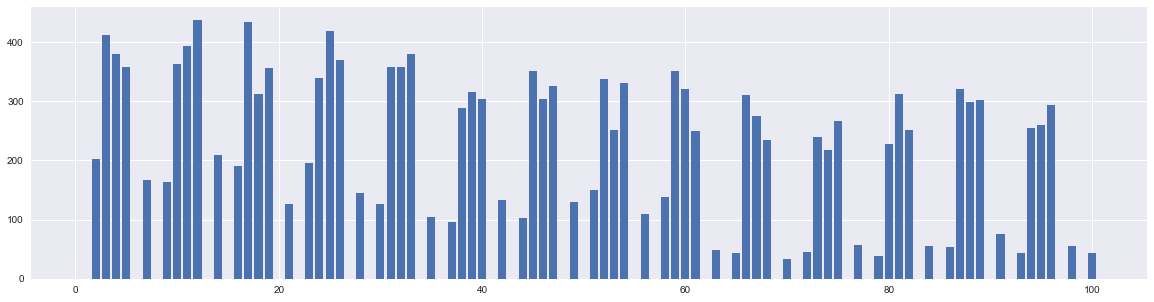

In [42]:
plt.close('all')
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,5))

bar = ax.bar(occupancy.index,occupancy['occ_count'])

## Trying to create stacked bars by picked option, currently doesn't work

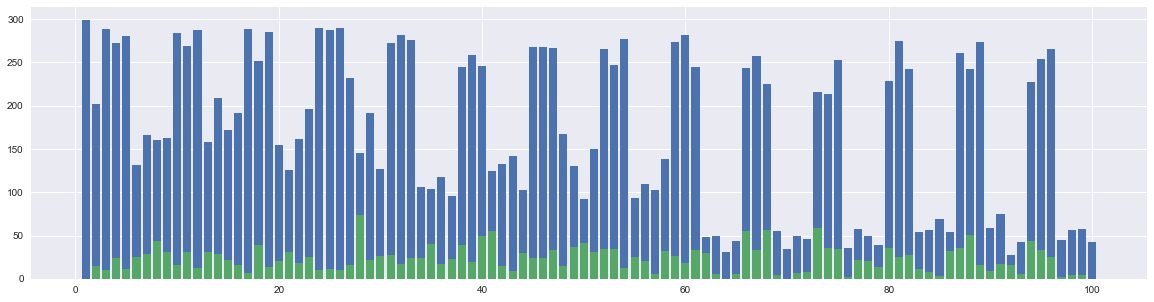

In [155]:
plt.close('all')
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,5))

a=0
data_agg0 = data[data['picked_choice_0']==a].groupby(['picked_day_0'])\
                .agg({'n_people':['sum']})\
                .reset_index().droplevel(1,axis=1)

bar1 = ax.bar(list(data_agg0['picked_day_0']),list(data_agg0['n_people']))


a=1
data_agg1 = data[data['picked_choice_0']==a].groupby(['picked_day_0'])\
                .agg({'n_people':['sum']})\
                .reset_index().droplevel(1,axis=1)

bar2 = ax.bar(list(data_agg1['picked_day_0']),list(data_agg1['n_people']))

# a=2
# data_agg2 = data[data['picked_choice_0']==a].groupby(['picked_day_0'])\
#                 .agg({'n_people':['sum']})\
#                 .reset_index().droplevel(1,axis=1)

# bar3 = ax.bar(list(data_agg2['picked_day_0']),list(data_agg2['n_people']))

# a=4
# data_agg3 = data[data['picked_choice_0']==a].groupby(['picked_day_0'])\
#                 .agg({'n_people':['sum']})\
#                 .reset_index().droplevel(1,axis=1)

# bar4 = ax.bar(list(data_agg3['picked_day_0']),list(data_agg3['n_people']))

# a=5
# data_agg4 = data[data['picked_choice_0']==a].groupby(['picked_day_0'])\
#                 .agg({'n_people':['sum']})\
#                 .reset_index().droplevel(1,axis=1)

# bar5 = ax.bar(list(data_agg4['picked_day_0']),list(data_agg4['n_people']))

# a=6
# data_agg = data[data['picked_choice_0']==a].groupby(['picked_day_0'])\
#                 .agg({'n_people':['sum']})\
#                 .reset_index().droplevel(1,axis=1)

# bar6 = ax.bar(list(data_agg['picked_day_0']),list(data_agg['n_people']))

# a=7
# data_agg = data[data['picked_choice_0']==a].groupby(['picked_day_0'])\
#                 .agg({'n_people':['sum']})\
#                 .reset_index().droplevel(1,axis=1)

# bar7 = ax.bar(list(data_agg['picked_day_0']),list(data_agg['n_people']))

# a=8
# data_agg = data[data['picked_choice_0']==a].groupby(['picked_day_0'])\
#                 .agg({'n_people':['sum']})\
#                 .reset_index().droplevel(1,axis=1)

# bar8 = ax.bar(list(data_agg['picked_day_0']),list(data_agg['n_people']))

# a=9
# data_agg = data[data['picked_choice_0']==a].groupby(['picked_day_0'])\
#                 .agg({'n_people':['sum']})\
#                 .reset_index().droplevel(1,axis=1)

# bar9 = ax.bar(list(data_agg['picked_day_0']),list(data_agg['n_people']))
